# JSON Helper Test



In [1]:
import io
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
class JsonLocationsHelper:

    def __init__(self, path):
        self.path = path
        self.classes = [x for x in os.listdir(path) if "." not in x]
        self.locations = None
        self.country_mapping = self.load_country_mapping()
        self.all_image_infos = {}
        self.load_all_locations()
        print(str(self.classes))

    def load_country_mapping(self):
        file_path = os.path.join(self.path, "country-alpha-2-mapping.json")

        with open(file_path, "r") as f:
            content = json.load(f)

        print("loaded {} country to alpha 2 code mappings.".format(len(content)))
        return content

    def load_all_locations(self):
        if self.locations is None:
            self.locations = {}
            for label in self.classes:
                self.locations[label.lower()] = self.load_locations_for_label(label)
        print("loaded {} labels".format(len(self.all_image_infos)))
        return self.locations

    def load_locations_for_label(self, label):
        print("load_locations_for_label > label: {}".format(label))
        label_path = os.path.join(self.path, label)
        locations = {}
        files = [x for x in os.listdir(label_path) if x.endswith("json")]
        i = 0
        for file in files:
            json_file_path = os.path.join(label_path, file)
            with open(json_file_path, "r") as f:
                image_id = os.path.splitext(file)[0]
                content = json.load(f)
                if content is not None:
                    country = content["attributes"]["table"]["country"]
                    id_infos = content["attributes"]["table"]
                    id_infos['id'] = image_id
                    if country is not None:

                        # get alpha 2 code
                        alpha_code = self.country_mapping.get(country.strip(), country.strip())
                        id_infos['country'] = alpha_code
                        if alpha_code not in locations:
                            locations[alpha_code] = []

                        i = i + 1
                        locations[alpha_code].append(id_infos)
                    self.all_image_infos[image_id] = id_infos
        print("load_locations_for_label > found {} locations".format(i))
        return locations

    def get_locations_for_label(self, label):
        if self.locations is None:
            self.load_all_locations()

        locations = self.locations.get(label.lower())
        return locations

    def get_all_labels(self):
        return self.classes

    def get_information_for_id(self, id):
        return self.all_image_infos[id]

    def get_all_ids(self):
        return list(self.all_image_infos.keys())


In [3]:
json_loader = JsonLocationsHelper("json/")
labels = json_loader.get_all_labels()

loaded 143 country to alpha 2 code mappings.
load_locations_for_label > label: Forest
load_locations_for_label > found 185 locations
load_locations_for_label > label: Glacier
load_locations_for_label > found 260 locations
load_locations_for_label > label: Galaxy
load_locations_for_label > found 184 locations
load_locations_for_label > label: Ruins
load_locations_for_label > found 210 locations
load_locations_for_label > label: Jungle
load_locations_for_label > found 141 locations
load_locations_for_label > label: Waterfalls
load_locations_for_label > found 215 locations
load_locations_for_label > label: Beach
load_locations_for_label > found 187 locations
load_locations_for_label > label: Desert
load_locations_for_label > found 189 locations
load_locations_for_label > label: Mountains
load_locations_for_label > found 223 locations
load_locations_for_label > label: Sea
load_locations_for_label > found 183 locations
loaded 1997 labels
['Forest', 'Glacier', 'Galaxy', 'Ruins', 'Jungle', 'W

In [4]:
def convert_dict_to_df(data):
    df_input = []
    for i in data.keys():
        places = data[i]
        for place in places:
            row = {}
            for k in place.keys():
                if k == 'position':
                    row['latitude'] = place[k]['latitude']
                    row['longitude'] = place[k]['longitude']
                else:
                    row[k] = place[k]
            df_input.append(row)
    return df_input

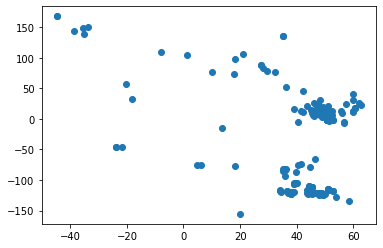

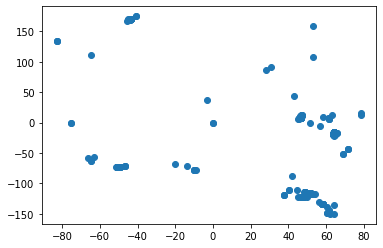

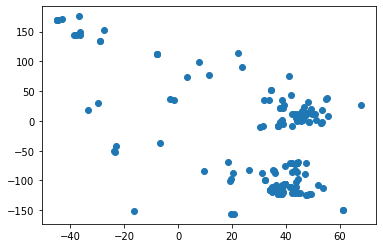

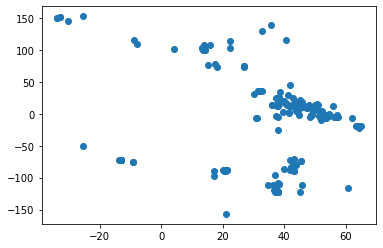

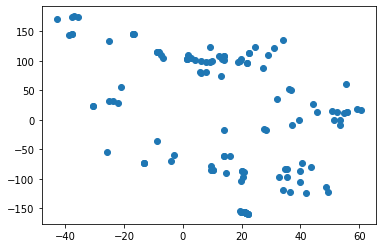

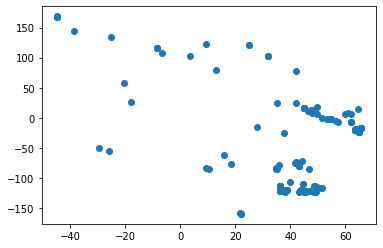

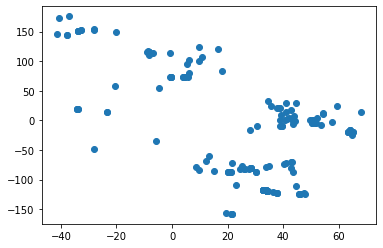

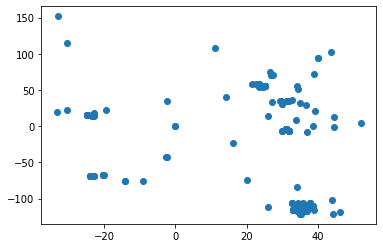

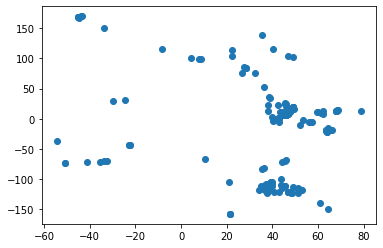

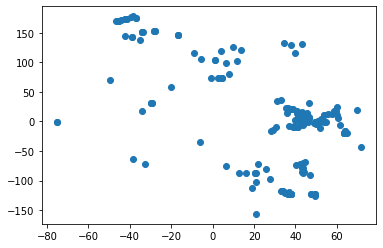

In [5]:
df_dict = {}
for l in labels:
    df_dict[l] = pd.DataFrame(convert_dict_to_df(json_loader.get_locations_for_label(l)))
    df = df_dict[l]
    plt.scatter(df.latitude, df.longitude)
    plt.show()

In [13]:
df_dict['Sea'][df_dict['Sea'].latitude.isna()]

,title,name,city,country,latitude,longitude,id
12,"Sea, Dénia, Spain",Sea,Dénia,ES,NaN,NaN,s-ImNJWdHrI
16,"prellezo, Prellezo, Spain","prellezo, mar cantabrico, sea, Cantabria, Spain",Prellezo,ES,NaN,NaN,HSj7Verc0cE
24,Florida,None,None,US,NaN,NaN,Hk91ys8MI0I
47,"New York, USA",None,New York,US,NaN,NaN,XsPM2CBTTpI
101,"Frederikssund, Denmark",None,Frederikssund,DK,NaN,NaN,DSwBHyWKiVw
140,"qingdao, China",None,qingdao,CN,NaN,NaN,bNQKQOmbfL8
150,"Cuxhaven, cuxhaven, Germany",Cuxhaven,cuxhaven,DE,NaN,NaN,vc3ZOCf5BN8


In [7]:
kms_per_radian = 6371.0088
epsilon = 100 / kms_per_radian

df_dbscan = {}
# caculate clusters for labels
for l in labels:
    # drop all null values in lat and long
    df = df_dict[l].dropna(subset=['latitude', 'longitude'])
    rads = np.radians(list(zip(df.latitude, df.longitude)))
    clusterer = DBSCAN(eps=epsilon,min_samples=1, metric='haversine')
    cluster_labels = clusterer.fit_predict(rads)
    print("{}: {} clusters for {} locations".format(l, len(set(cluster_labels)), len(df)))
    #print(cluster_labels)
    df_dbscan[l] = df.assign(cluster=cluster_labels)
    cl, counts = np.unique(cluster_labels[cluster_labels>=0], return_counts=True)
    print("Cluster {} has {} elements".format(cl[np.argsort(-counts)[1]], counts[np.argsort(-counts)[1]]))
    print()

Forest: 98 clusters for 181 locations
Cluster 19 has 11 elements

Glacier: 55 clusters for 256 locations
Cluster 9 has 28 elements

Galaxy: 115 clusters for 180 locations
Cluster 0 has 10 elements

Ruins: 116 clusters for 206 locations
Cluster 1 has 15 elements

Jungle: 92 clusters for 138 locations
Cluster 14 has 7 elements

Waterfalls: 65 clusters for 211 locations
Cluster 7 has 17 elements

Beach: 93 clusters for 182 locations
Cluster 26 has 8 elements

Desert: 70 clusters for 181 locations
Cluster 6 has 12 elements

Mountains: 92 clusters for 220 locations
Cluster 8 has 12 elements

Sea: 117 clusters for 176 locations
Cluster 64 has 4 elements



,title,name,city,country,latitude,longitude,id,cluster
27,"Church Mountain, United States",Church Mountain,None,US,48.926791,-121.882088,Mlau3q2SRGw,19
69,"Lynn Canyon Park, North Vancouver, Canada",Lynn Canyon Park,North Vancouver,CA,49.343884,-123.018114,xY_6ZENqcfo,19
72,"Vancouver, Canada",Vancouver,Vancouver,CA,49.282729,-123.120738,YCkaIiVBHNg,19
74,"Cypress Mountain, Vancouver, Canada",Cypress Mountain,Vancouver,CA,49.396018,-123.204545,yAFKdGlUkyI,19
76,"Whyte Lake Trail, West Vancouver, Canada",Whyte Lake Trail,West Vancouver,CA,49.374950,-123.260308,GeHVEDrqMB8,19
78,"Capilano Suspension Bridge, West Vancouver, Ca...",Capilano Suspension Bridge,West Vancouver,CA,49.342890,-123.115059,PWZVfvrfnLQ,19
80,"Whistler, Canada",Whistler,Whistler,CA,50.116320,-122.957356,Q4oN2CTw6GI,19
82,"Mount Seymour, Canada",Mount Seymour,None,CA,49.393333,-122.944444,XeEfTJVtM80,19
83,"Westwood Lake Trail, Nanaimo, Canada",Westwood Lake Trail,Nanaimo,CA,49.160460,-124.004331,EPmvy-Ql4U0,19
84,"Squamish, Canada",Squamish,Squamish,CA,49.701634,-123.155812,5Yid6z90aHg,19


Text(0.5, 1.0, 'Forest')

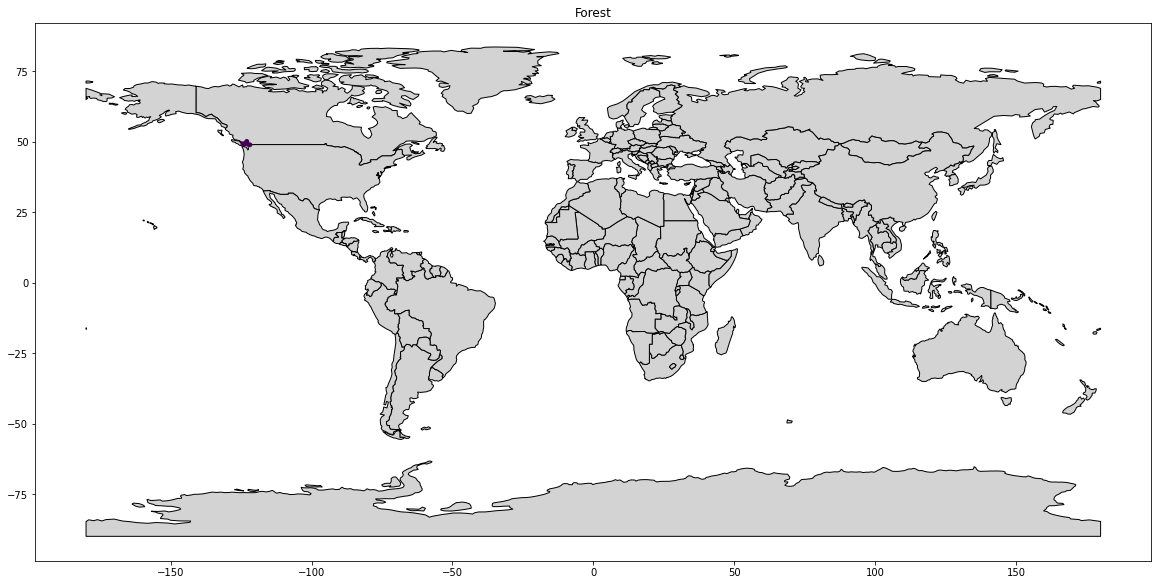

In [8]:
l = "Forest"
df1 = df_dbscan[l]
df1 = df1[df1.cluster == 19]
display(df1)
geometry = [Point(xy) for xy in zip(df1['longitude'], df1['latitude'])]
gdf = GeoDataFrame(df1, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = gdf.plot(ax=world.plot(figsize=(20, 12), color='lightgrey', edgecolor='black'), marker='o', c=df1.cluster, markersize=15);
ax.set_title(l)

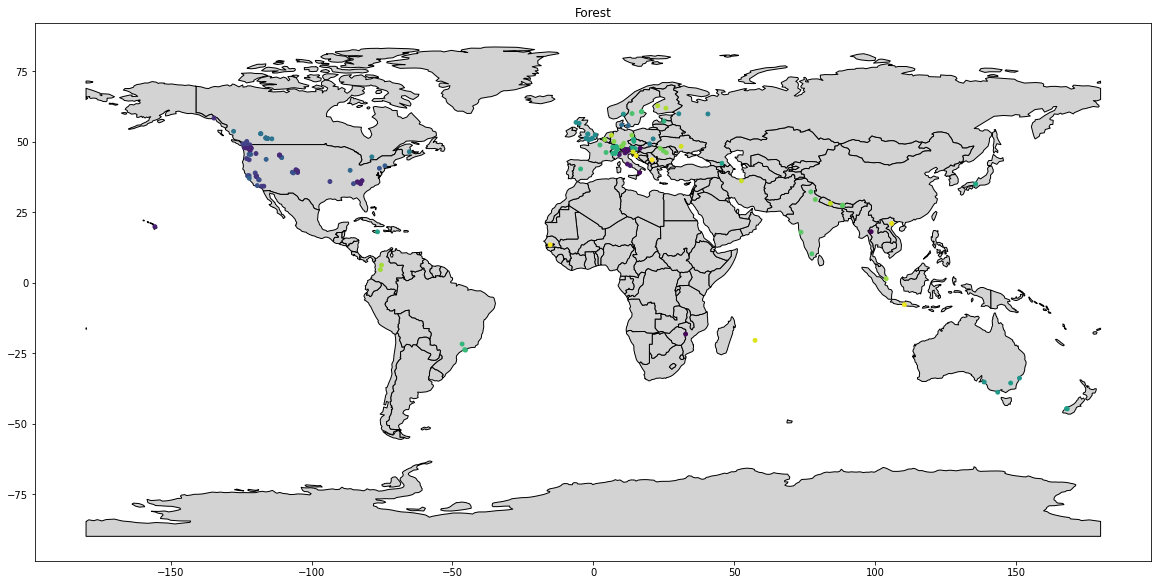

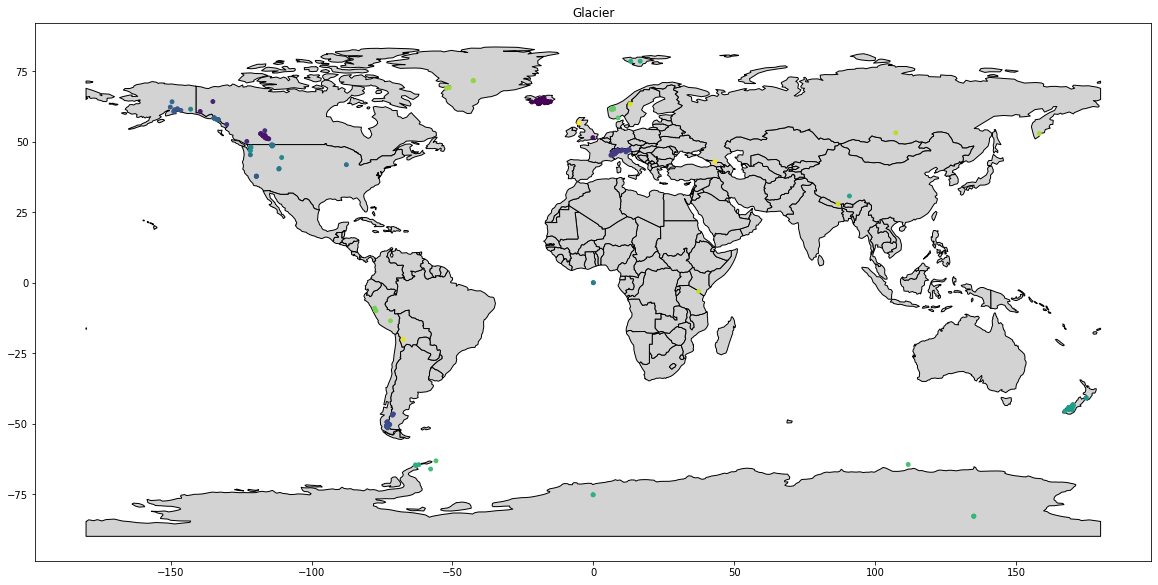

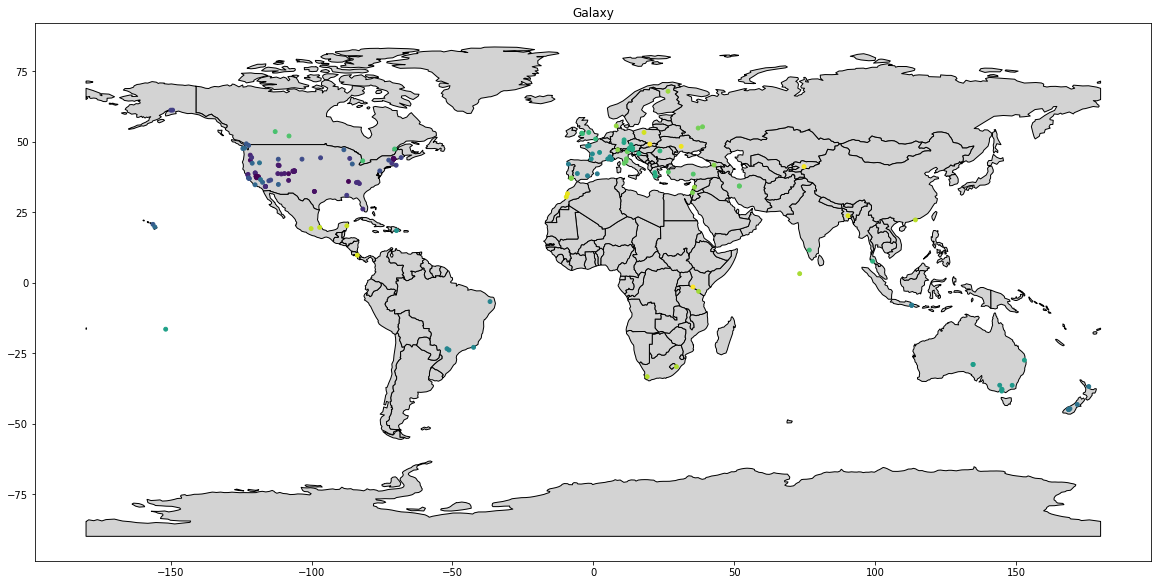

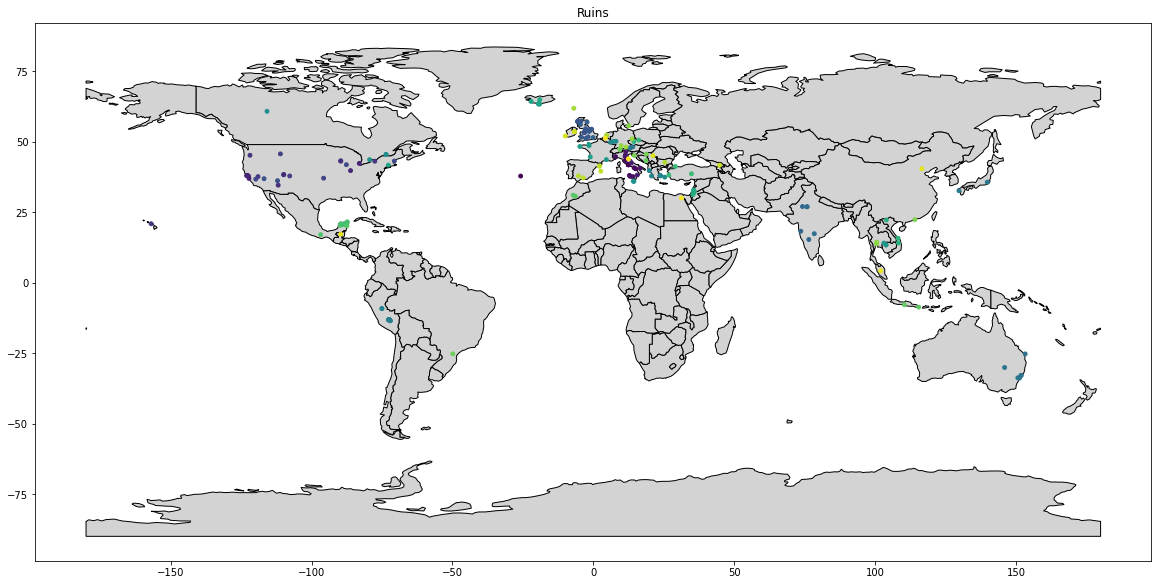

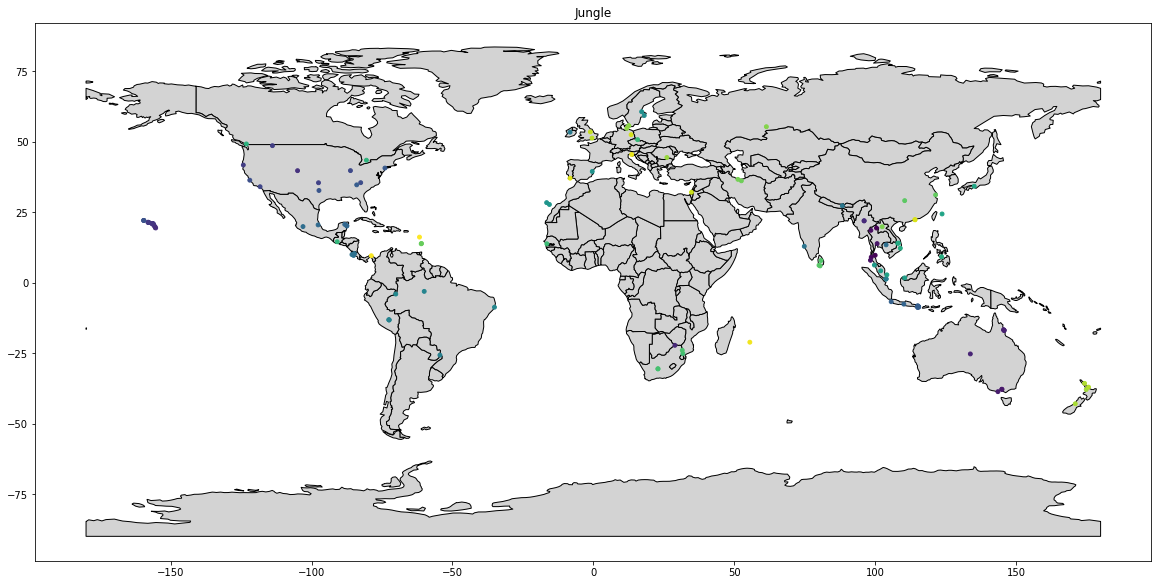

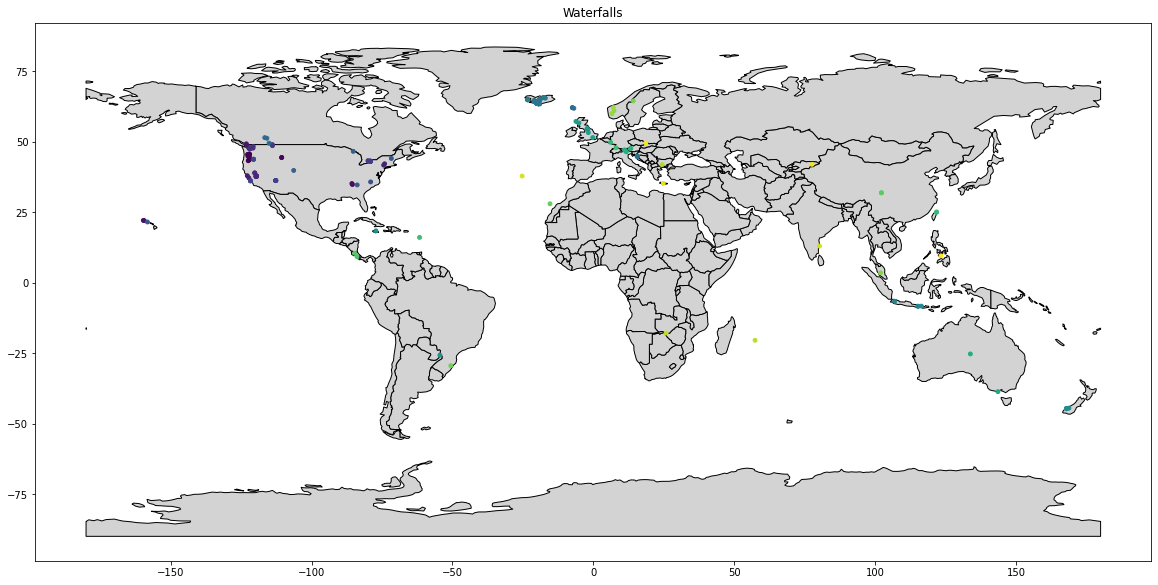

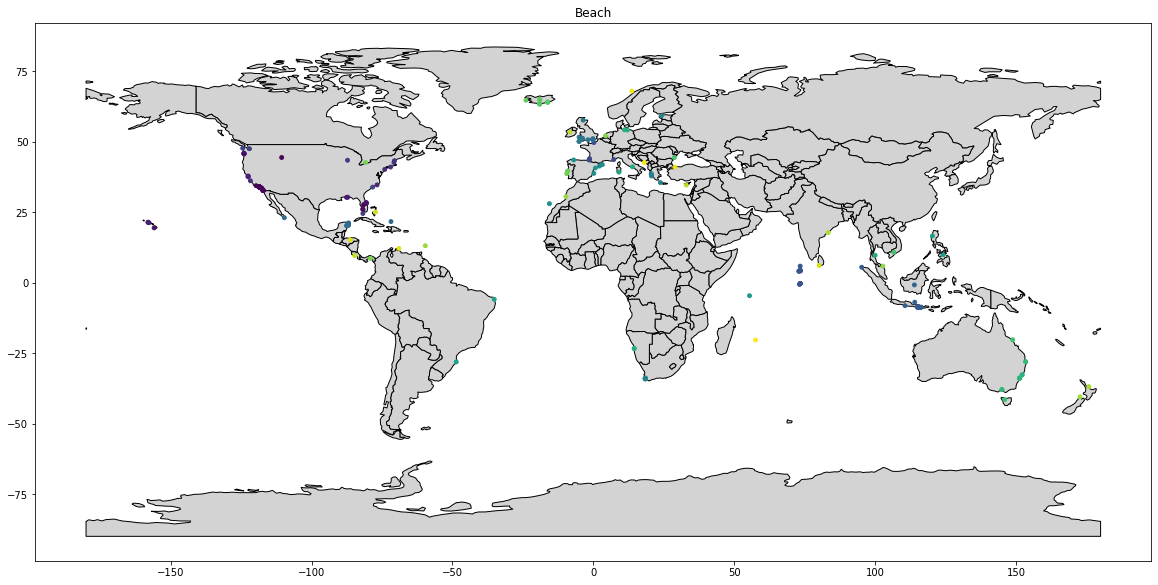

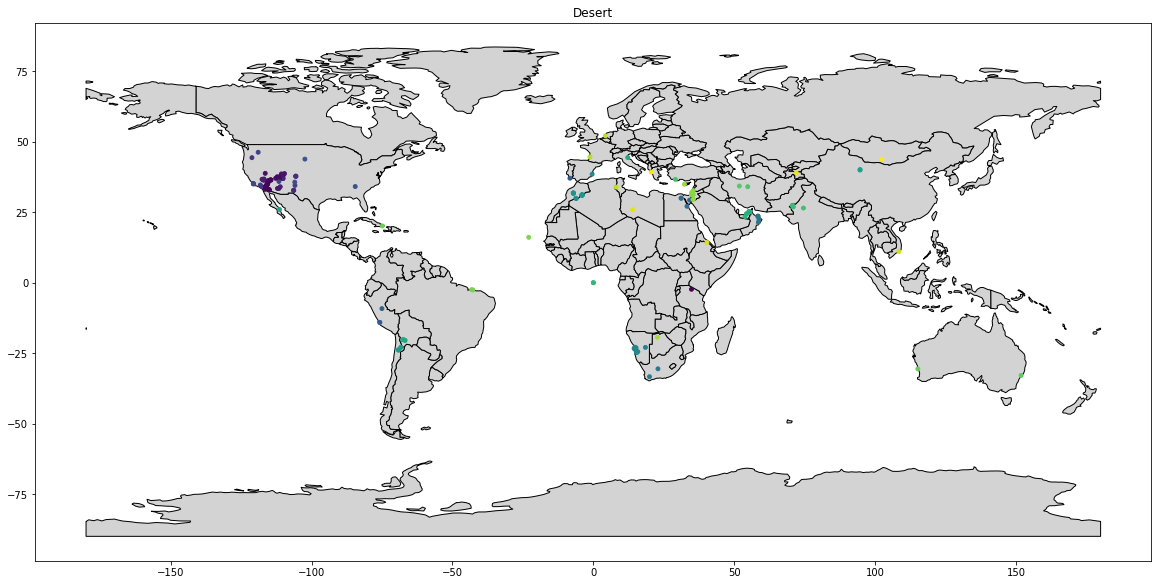

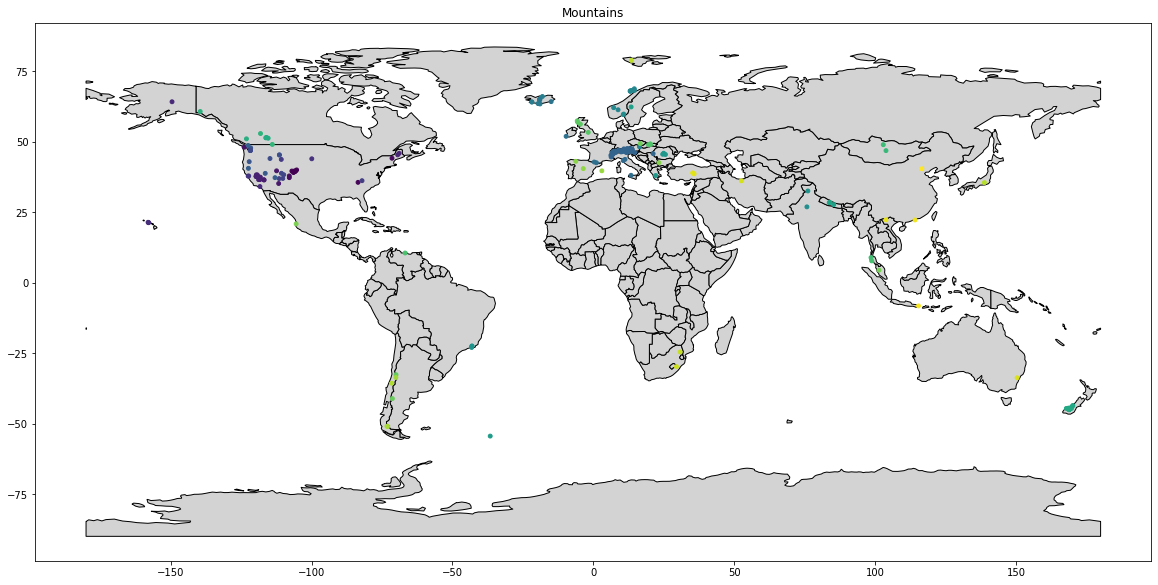

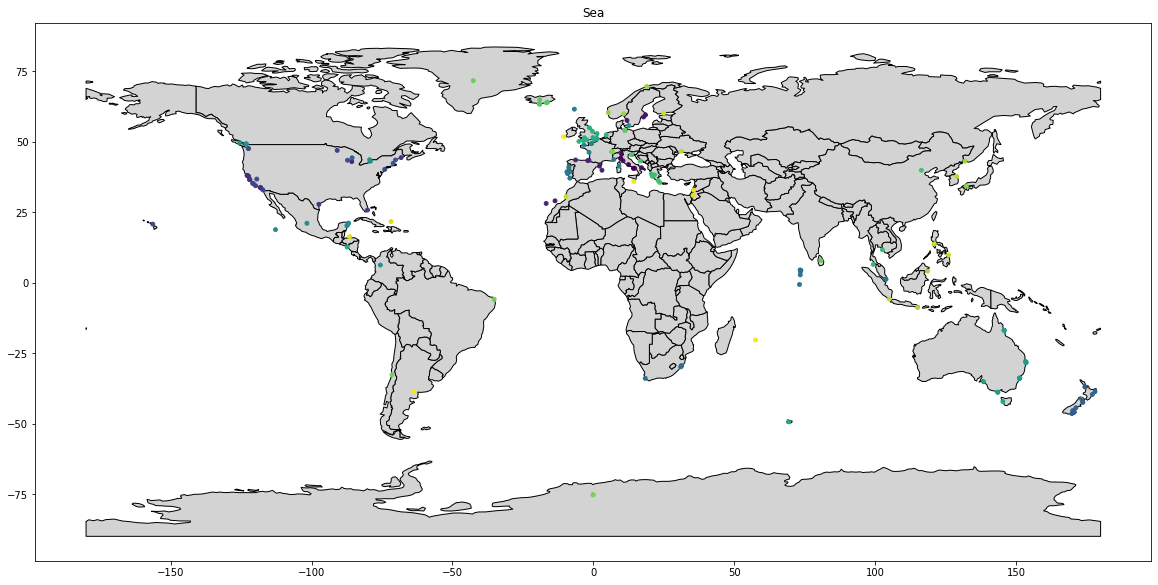

In [9]:
for l in labels:
    df1 = df_dbscan[l]
    geometry = [Point(xy) for xy in zip(df1['longitude'], df1['latitude'])]
    gdf = GeoDataFrame(df1, geometry=geometry)   

    #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = gdf.plot(ax=world.plot(figsize=(20, 12), color='lightgrey', edgecolor='black'), marker='o', c=df1.cluster, markersize=15);
    ax.set_title(l)